# Infra and Extra Marginal Treatment Effects
Julian Hsu
26-July-2023

The purpose of this script is to show that while we can estimate the average treatment effect, this average can hide variation in the estimate. Specifically when there are different impacts at the external margin (treated at all versus not) and internal margin (how treated are you?).

Consider a case where the outcome depends on these different margins:

$$ Y_i = \beta X_i + \omega_0 1\{ w_i > 0 \}  + \omega_1 w_i + \eta_i $$

here $\omega_0$ captures the extrnal margin, and $\omega_1$ captures the internal margin. We allow $\beta X_i$ to have some explainable noise.


**Sound byte** Is your treatment continuous? Even though in most experiments we assign treatment and controlg roups, we can also have different types of treatment groups. In particularly if we are introducing a new feature like the duration of new ad campaigns or price of a new product. Often we care about two things: whether a unit is given the treatment at all (new ad or not), and how it is given (new ad duration). Then it matters how you model your treatment.

 To capture the two things, you need to model both of them. I show with simulation data that when you have control and treated units with varying treatment values, modeling the treatment as binary doesn't capture the continuous part, and modeling treatment only as continuous misses that some are not treated at all. Check out the notebook link here(https://github.com/shoepaladin/causalinference_crashcourse/blob/main/OtherMaterial/Precision%20Benefits%20from%20Interpolating%20and%20Extrapolating%20from%20Experiments.ipynb).

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt



## Write functions to generate data
We assume random experimentation for now.

In [24]:
def dgp(N=1000, w0=2, w1=3 ):
    X = np.random.uniform(0,1, N)
    ## Let 25% of w be zero
    w = np.random.uniform(0.5,3, N)
    w[0: int(N*0.25)] = 0
    
    ## Create the treatment effect
    gt = w0*(w>0) + w1*w
    
    ## Create the outcome
    y = 2 + np.random.uniform(0.25,1)*X  + np.random.normal(0,1,N)
    y += gt
    
    return pd.DataFrame(data={'x':X, 'w':w, 'y':y, 'gt':gt})

## Write functions for estimating impacts.
These functions should output the predicted impact

In [25]:
def ols_linear(data=None):
    ols_fe_model = sm.OLS(data['y'], sm.add_constant(data[['x','w']])).fit()
    treatment = data['w']*ols_fe_model.params['w']
    return ols_fe_model, treatment


def ols_external_only(data=None):
    data['w_nonzero'] = (data['w'] > 0).astype(float)
    ols_fe_model = sm.OLS(data['y'], sm.add_constant(data[['x','w_nonzero']])).fit()
    treatment = data['w_nonzero']*ols_fe_model.params['w_nonzero']
    
    return ols_fe_model, treatment


def ols_external_and_linear(data=None):
    data['w_nonzero'] = (data['w'] > 0).astype(float)
    ols_fe_model = sm.OLS(data['y'], sm.add_constant(data[['x','w_nonzero','w']])).fit()
    treatment = data['w_nonzero']*ols_fe_model.params['w_nonzero'] + data['w']*ols_fe_model.params['w']
    
    return ols_fe_model,treatment



In [26]:
df = dgp(N=200, w0=2, w1=3)
display( df.loc[df['w']>0]['gt'].mean() )
hat = ols_external_only( df )
df['hat_external_only'] = hat[1]

hat_linear = ols_linear( df )
df['hat_linear'] = hat_linear[1]

hat_external_linear = ols_external_and_linear( df )
df['hat_external_linear'] = hat_external_linear[1]



# display( df.loc[df['w']>0][['gt','hat_external_only']].describe() 2

7.4536122819805115

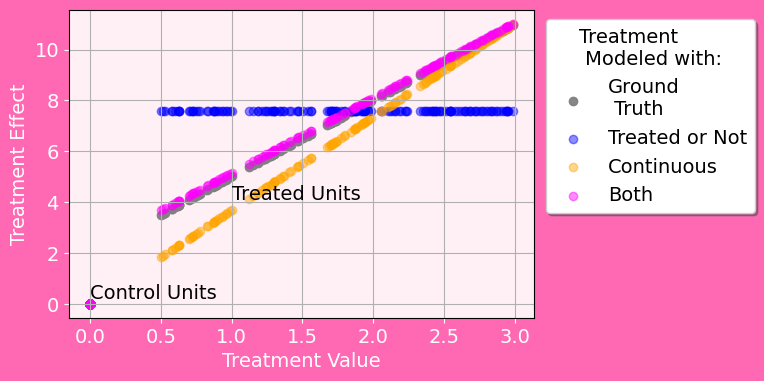

In [27]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plot_data = df.loc[df['w']>0 ]
plot_data = df.copy()
plot_data.sort_values(by='w',inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)


ax.scatter(plot_data['w'], plot_data['gt'],                   color='grey', alpha=0.95,  label='Ground\n Truth')
ax.scatter(plot_data['w'], plot_data['hat_external_only'],    color='blue', alpha=0.45,  label='Treated or Not')
ax.scatter(plot_data['w'], plot_data['hat_linear'],           color='orange', alpha=0.45,  label='Continuous')
ax.scatter(plot_data['w'], plot_data['hat_external_linear'],  color='magenta', alpha=0.45,  label='Both')
ax.text(s='Control Units',x=0,y=0.2)
ax.text(s='Treated Units',x=1,y=4.1)
ax.legend(title='Treatment \n Modeled with:',
          loc='upper center', bbox_to_anchor=(1.25, 1.0),
          fancybox=True, shadow=True)


ax.set_ylabel('Treatment Effect')
ax.set_xlabel('Treatment Value')

ax.grid()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_facecolor('lavenderblush')
fig.set_facecolor('hotpink')
plt.show()
